C:\Users\ishaan256185\AppData\Local\Temp\ipykernel_23136\4078358321.py:67: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  series = unres.groupby(pd.Grouper(key="timestamp", freq=RESAMPLE)).size()


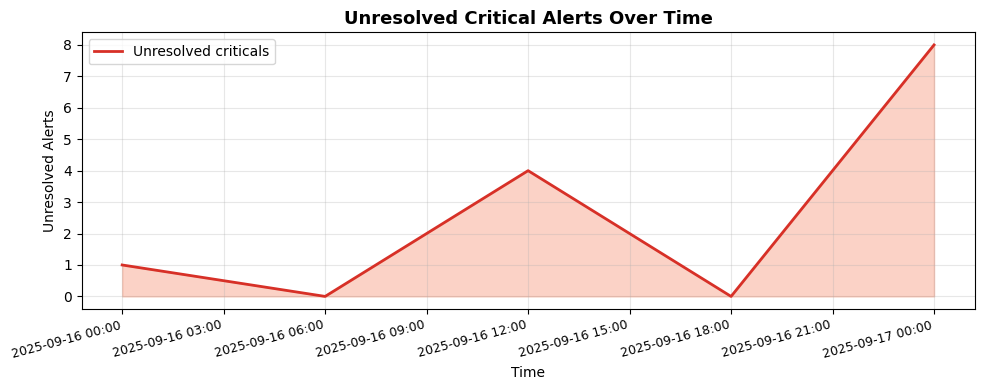

In [2]:
ALERTS_PATH = r"C:\engine_module_pipeline\infer_stage\delta\engine_module_alerts"
RESAMPLE = "6H"

import numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib.dates as mdates
from pathlib import Path

def load_alerts(path):
    p = Path(path)
    if p.is_dir() and (p / "_delta_log").exists():
        try:
            from deltalake import DeltaTable
            return DeltaTable(str(p)).to_pandas()
        except Exception:
            files = list(p.glob("*.parquet"))
            if files:
                return pd.concat([pd.read_parquet(str(f)) for f in files], ignore_index=True)
            else:
                raise RuntimeError(f"Can't read Delta path: {p}")
    elif p.is_file():
        return pd.read_parquet(str(p)) if p.suffix.lower() in (".parquet", ".pq") else pd.read_csv(str(p))
    else:
        raise FileNotFoundError(f"alerts path not found: {path}")

# --- Load table ---
alerts = load_alerts(ALERTS_PATH)

# --- Normalize timestamp ---
alerts["timestamp"] = pd.to_datetime(
    alerts.get("alert_ts", alerts.get("timestamp")),
    errors="coerce", utc=True
).dt.tz_convert("UTC").dt.tz_localize(None)

# --- Normalize severity ---
alerts["severity"] = pd.to_numeric(
    alerts.get("severity_level", alerts.get("severity", np.nan)),
    errors="coerce"
)

# --- Normalize resolved flag robustly ---
if "resolved_flag" in alerts.columns:
    col = alerts["resolved_flag"]
elif "resolved" in alerts.columns:
    col = alerts["resolved"]
elif "is_resolved" in alerts.columns:
    col = alerts["is_resolved"]
else:
    # fallback: no column at all
    col = pd.Series([False] * len(alerts), index=alerts.index)

# ensure Series and string conversion safety
if not isinstance(col, pd.Series):
    col = pd.Series([col] * len(alerts), index=alerts.index)

col_str = col.astype(str).str.lower().fillna("false")
alerts["_resolved_flag"] = col_str.isin(["true", "1", "yes"])

# --- Filter critical and unresolved alerts ---
mask_crit = alerts["severity"] == 3
mask_unresolved = ~alerts["_resolved_flag"]
unres = alerts[mask_crit & mask_unresolved].copy()

# --- Group and plot ---
if unres.empty:
    print("No unresolved critical alerts found.")
else:
    series = unres.groupby(pd.Grouper(key="timestamp", freq=RESAMPLE)).size()
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(series.index, series.values, color="#d73027", linewidth=2, label="Unresolved criticals")
    ax.fill_between(series.index, series.values, color="#f46d43", alpha=0.3)
    ax.set_title("Unresolved Critical Alerts Over Time", fontsize=13, weight="bold")
    ax.set_xlabel("Time")
    ax.set_ylabel("Unresolved Alerts")
    ax.grid(alpha=0.3)
    ax.legend(loc="upper left")
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d %H:%M"))
    plt.setp(ax.get_xticklabels(), rotation=15, ha="right", fontsize=9)
    plt.tight_layout()
    plt.show()
